In [2]:
!tar -xzf /kaggle/input/task-s/binding_affinity_data.tar.xz
!pip install pylcs blosum torcheval --quiet

In [3]:
import pandas as pd
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm
import pylcs
DEVICE = 'cuda'

In [4]:
df = pd.read_csv('/kaggle/working/binding_affinity_data.csv')
df = df[df['MHC_sequence'].apply(len) > 300]
df.reset_index(inplace=True)

seqs = df['MHC_sequence'].unique().tolist()
mhc_type_to_seq = {df['MHC_type'][i]: df['MHC_sequence'][i] for i in range(len(df))}
mhc_types = [t for t, seq in mhc_type_to_seq.items()]
mhc_type_to_idx = {t: i for i, t in enumerate(mhc_types)}

In [5]:
amino_acids = list(sorted(set(''.join(df['peptide_sequence'].tolist())))) + ['-', '*']
aa_to_idx = {aa: i for i, aa in enumerate(amino_acids)}
START_TOKEN = aa_to_idx['*']
PEPTIDE_LEN = 15
def encode_peptide(peptide_str):
    return [START_TOKEN] + [aa_to_idx[peptide_str[i]] if i < len(peptide_str) else aa_to_idx['-']  for i in range(PEPTIDE_LEN - 1)]

In [6]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

X_pep = torch.tensor(np.stack(df['peptide_sequence'].apply(lambda t: np.array(encode_peptide(t))).to_numpy()), device=DEVICE)
X_tmhc = torch.tensor(df['MHC_type'].apply(lambda t: mhc_type_to_idx[t]).to_numpy(), device=DEVICE)
Y = torch.tensor(df['label'].to_numpy(), device=DEVICE)

train_idx, valid_idx = train_test_split(
    np.arange(len(df)), 
    test_size=0.2, 
    shuffle=True, 
    stratify=df.apply(lambda x: mhc_type_to_idx[x['MHC_type']] * 2 + x['label'], axis=1).to_numpy()
)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [7]:
BATCH_SIZE = 1024

training_data = TensorDataset(X_pep[train_idx], X_tmhc[train_idx], Y[train_idx])
val_data = TensorDataset(X_pep[valid_idx], X_tmhc[valid_idx], Y[valid_idx])

train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)

In [122]:
import math
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len):
        super().__init__()

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.squeeze(1))

    def forward(self, x):
        x = x + self.pe[:x.size(1)].unsqueeze(0)
        return x

class Block(nn.Module):
    def __init__(self, embed_dim=32, num_heads=4, *args, **kwargs):
        super(Block, self).__init__()
        self.ln_1 = nn.LayerNorm(embed_dim)

        self.kw, self.qw, self.vw = nn.Linear(embed_dim, embed_dim), nn.Linear(embed_dim, embed_dim), nn.Linear(embed_dim, embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)

        self.ln_2 = nn.LayerNorm(embed_dim)

        self.c_fc    = nn.Linear(embed_dim, 4 * embed_dim)
        self.gelu    = nn.GELU()
        self.c_proj  = nn.Linear(4 * embed_dim, embed_dim)
        self.dropout = nn.Dropout(0)
        
    def forward(self, x, return_weights=False):
        x = self.ln_1(x)
        a, w = self.attn(self.qw(x), self.kw(x), self.vw(x))
        x = x + a
        x = self.ln_2(x)
        x = x + self.dropout(self.c_proj(self.gelu(self.c_fc(x))))
        if return_weights:
            return x, w
        return x
    
class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()
        EMB = 32
        self.pep = nn.Sequential(
            nn.Embedding(len(amino_acids), EMB), # .from_pretrained(bl_embedding),
            PositionalEncoding(EMB, max_len=PEPTIDE_LEN),
            nn.Tanh(),
            *[Block(embed_dim=EMB, num_heads=4) for i in range(3)],
        )
        LNS = 10
        self.head = nn.Sequential(
            nn.Linear(EMB, LNS),
            nn.Sigmoid()
        )
        self.mhc = nn.Sequential(
            nn.Embedding(len(mhc_types), LNS),
            nn.Softmax(dim=-1)
        )
        with torch.no_grad():
            self.mhc[0].weight /= 10
    
    def forward(self, x, x_mhc):
        x = self.pep(x)[:, 0, :].squeeze(1)  # peptide representation
        x = self.head(x)
        cl = self.mhc(x_mhc)
        return (cl * x).sum(dim=-1, keepdim=True)

model = BaseModel().to(DEVICE)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))
loss_fn = nn.BCELoss(reduction='none')
# optimizer = torch.optim.AdamW(model.parameters())
from torch.optim.lr_scheduler import ReduceLROnPlateau
optimizer = torch.optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 10, 1, verbose=True)
# scheduler = ReduceLROnPlateau(optimizer, 'max', patience=3, verbose=True)

49710
Epoch 00000: adjusting learning rate of group 0 to 1.0000e-03.


In [ ]:
# visualize different mhc embeddings
with torch.no_grad():
    plt.imshow(
        model.mhc(torch.tensor([[i for i in range(len(mhc_types))]]).cuda()).squeeze(0).cpu()
    )

In [106]:
from torcheval.metrics.functional import binary_f1_score, binary_precision, binary_recall, binary_auroc

def val_model(model, dataloader):
    model.eval()
    val_loss = 0
    results = []
    targets = []
    with torch.no_grad():
        for x_pep, x_tmhc, target in dataloader:
            res = model(x_pep, x_tmhc)
            results.append(res)
            targets.append(target)
            val_loss += (loss_fn(res.reshape(-1), target.reshape(-1).float())).sum().item() # * class_w[target]).sum().item()
    
    res = torch.concat(results).reshape(-1)
    target = torch.concat(targets)
    accuracy = (res.reshape(-1).round() == target.reshape(-1)).float().mean().item()
    val_loss /= len(val_dataloader.dataset)
    return val_loss, accuracy, binary_auroc(res, target).item(), binary_precision(res, target).item(), binary_recall(res, target).item(), binary_f1_score(res, target).item()
# binary_f1_score(res, target).item(), binary_precision(res, target).item(), binary_recall(res, target).item()

In [123]:
running_loss = []
running_val_loss = []
running_val_loss_idx = []
running_acc = []
running_auroc = []
running_percision = []
running_recall = []
running_f1 = []
upds = 0

In [ ]:
epochs = 90
for i in range(epochs):
    last_auroc = 0
    for x_pep, x_tmhc, target in tqdm(train_dataloader):
        model.train()
        res = model(x_pep, x_tmhc)
        loss = (loss_fn(res.reshape(-1), target.reshape(-1).float())).mean() # * class_w[target]).mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss.append(loss.item())
        upds += 1
    #if upds % 1382 == 1:
    val_loss, accuracy, auroc, percision, recall, f1 = val_model(model, val_dataloader)
    last_auroc = auroc
    running_val_loss.append(val_loss)
    running_acc.append(accuracy)
    running_auroc.append(auroc)
    running_percision.append(percision)
    running_recall.append(recall)
    running_f1.append(f1)
    running_val_loss_idx.append(upds)
    # scheduler.step(last_auroc)
    print(f'Train: {np.mean(running_loss[-690:])} | Val: {val_loss}')
    print(f'Train: {binary_auroc(res.reshape(-1), target)} | Val: {auroc}')
    scheduler.step()
    # print(np.round(running_auroc, decimals=4)[-5:])
    '''if i % 5 == 0:
        # plot_state()
        PATH = f"model-{i}.pt"
        torch.save({
            'epoch': i,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, PATH
        )'''

100%|██████████| 1382/1382 [00:45<00:00, 30.44it/s]


Train: 0.28347647447085034 | Val: 0.26839730266787687
Train: 0.9243380805559633 | Val: 0.9265060692912842
Epoch 00001: adjusting learning rate of group 0 to 9.7553e-04.


100%|██████████| 1382/1382 [00:43<00:00, 31.44it/s]


Train: 0.23235165623651036 | Val: 0.2239348650325818
Train: 0.9368004368004368 | Val: 0.9502507104493367
Epoch 00002: adjusting learning rate of group 0 to 9.0451e-04.


100%|██████████| 1382/1382 [00:43<00:00, 31.47it/s]


Train: 0.20427771893100463 | Val: 0.20157834230027416
Train: 0.9658009279188788 | Val: 0.9591114597218181
Epoch 00003: adjusting learning rate of group 0 to 7.9389e-04.


100%|██████████| 1382/1382 [00:44<00:00, 31.17it/s]


Train: 0.19162065496911174 | Val: 0.19133026339633535
Train: 0.9705519656686233 | Val: 0.962606799932581
Epoch 00004: adjusting learning rate of group 0 to 6.5451e-04.


100%|██████████| 1382/1382 [00:43<00:00, 31.90it/s]


Train: 0.1842352300234463 | Val: 0.18410224534337646
Train: 0.975430692862804 | Val: 0.9655409968337821
Epoch 00005: adjusting learning rate of group 0 to 5.0000e-04.


100%|██████████| 1382/1382 [00:43<00:00, 31.63it/s]


Train: 0.1779204363624255 | Val: 0.1800432328027914
Train: 0.9744663488382082 | Val: 0.9668893761670682
Epoch 00006: adjusting learning rate of group 0 to 3.4549e-04.


100%|██████████| 1382/1382 [00:43<00:00, 31.93it/s]


Train: 0.17398976858543314 | Val: 0.1763114181177064
Train: 0.9786402769979412 | Val: 0.9679834523028698
Epoch 00007: adjusting learning rate of group 0 to 2.0611e-04.


100%|██████████| 1382/1382 [00:43<00:00, 31.58it/s]


Train: 0.17132315521222957 | Val: 0.17479149996109378
Train: 0.9792335524639454 | Val: 0.9684592486791923
Epoch 00008: adjusting learning rate of group 0 to 9.5492e-05.


100%|██████████| 1382/1382 [00:43<00:00, 31.98it/s]


Train: 0.1698089687720589 | Val: 0.1731662850933208
Train: 0.972089650009358 | Val: 0.9690348038661036
Epoch 00009: adjusting learning rate of group 0 to 2.4472e-05.


100%|██████████| 1382/1382 [00:43<00:00, 31.96it/s]


Train: 0.167838482418354 | Val: 0.1723815872235312
Train: 0.9616385542168675 | Val: 0.9693150688851964
Epoch 00010: adjusting learning rate of group 0 to 1.0000e-03.


100%|██████████| 1382/1382 [00:43<00:00, 31.65it/s]


Train: 0.17472908073577328 | Val: 0.17508883511110196
Train: 0.9644362216055093 | Val: 0.9683467133815916
Epoch 00011: adjusting learning rate of group 0 to 9.7553e-04.


100%|██████████| 1382/1382 [00:43<00:00, 32.01it/s]


Train: 0.1712984978072885 | Val: 0.1726303331194642
Train: 0.9721718931475029 | Val: 0.9691826022678571
Epoch 00012: adjusting learning rate of group 0 to 9.0451e-04.


100%|██████████| 1382/1382 [00:43<00:00, 31.49it/s]


Train: 0.16690465602753818 | Val: 0.17113889990537423
Train: 0.9789303438496987 | Val: 0.9701059845371799
Epoch 00013: adjusting learning rate of group 0 to 7.9389e-04.


100%|██████████| 1382/1382 [00:43<00:00, 31.98it/s]


Train: 0.1639966161786646 | Val: 0.1666190642984804
Train: 0.9717111428994228 | Val: 0.9712638408961448
Epoch 00014: adjusting learning rate of group 0 to 6.5451e-04.


100%|██████████| 1382/1382 [00:43<00:00, 31.99it/s]


Train: 0.16079475108696067 | Val: 0.1650127484072959
Train: 0.9683093576413616 | Val: 0.9720998319943064
Epoch 00015: adjusting learning rate of group 0 to 5.0000e-04.


100%|██████████| 1382/1382 [00:43<00:00, 31.93it/s]


Train: 0.15897180414286213 | Val: 0.1638714912753992
Train: 0.957406810613385 | Val: 0.9726678235009066
Epoch 00016: adjusting learning rate of group 0 to 3.4549e-04.


100%|██████████| 1382/1382 [00:43<00:00, 31.83it/s]


Train: 0.15536014530537784 | Val: 0.1603672537289216
Train: 0.9699550209733664 | Val: 0.9732525777584665
Epoch 00017: adjusting learning rate of group 0 to 2.0611e-04.


100%|██████████| 1382/1382 [00:43<00:00, 31.42it/s]


Train: 0.15356638702577438 | Val: 0.15968689303098613
Train: 0.966365999082709 | Val: 0.9734781594131483
Epoch 00018: adjusting learning rate of group 0 to 9.5492e-05.


100%|██████████| 1382/1382 [00:43<00:00, 31.63it/s]


Train: 0.15148873826947765 | Val: 0.15881618440270032
Train: 0.9776771196283391 | Val: 0.9737693611051232
Epoch 00019: adjusting learning rate of group 0 to 2.4472e-05.


100%|██████████| 1382/1382 [00:44<00:00, 31.07it/s]


Train: 0.14993076581453932 | Val: 0.15827260088786102
Train: 0.9703373493975903 | Val: 0.9738753548413738
Epoch 00020: adjusting learning rate of group 0 to 1.0000e-03.


100%|██████████| 1382/1382 [00:44<00:00, 31.39it/s]


Train: 0.1602132015578125 | Val: 0.16485845927591616
Train: 0.9791484061447617 | Val: 0.9718852892244029
Epoch 00021: adjusting learning rate of group 0 to 9.7553e-04.


100%|██████████| 1382/1382 [00:43<00:00, 31.59it/s]


Train: 0.15841243943010552 | Val: 0.16319921638955057
Train: 0.9689895470383275 | Val: 0.972362823202959
Epoch 00022: adjusting learning rate of group 0 to 9.0451e-04.


100%|██████████| 1382/1382 [00:43<00:00, 31.44it/s]


Train: 0.1571980072968248 | Val: 0.16112746270163716
Train: 0.9782459305072371 | Val: 0.9730495849328218
Epoch 00023: adjusting learning rate of group 0 to 7.9389e-04.


100%|██████████| 1382/1382 [00:43<00:00, 31.60it/s]


Train: 0.15516699030995368 | Val: 0.1615470230969533
Train: 0.968261990195583 | Val: 0.9732618790410112
Epoch 00024: adjusting learning rate of group 0 to 6.5451e-04.


100%|██████████| 1382/1382 [00:44<00:00, 31.41it/s]


Train: 0.151831086455048 | Val: 0.15866627130339483
Train: 0.9854067223548131 | Val: 0.9737593443393059
Epoch 00025: adjusting learning rate of group 0 to 5.0000e-04.


100%|██████████| 1382/1382 [00:44<00:00, 31.03it/s]


Train: 0.1502830988794997 | Val: 0.15765540054884544
Train: 0.981537284163199 | Val: 0.9741598105482063
Epoch 00026: adjusting learning rate of group 0 to 3.4549e-04.


100%|██████████| 1382/1382 [00:44<00:00, 30.87it/s]


Train: 0.14830420502070069 | Val: 0.15637787390737468
Train: 0.9740588421385638 | Val: 0.9744772806974776
Epoch 00027: adjusting learning rate of group 0 to 2.0611e-04.


100%|██████████| 1382/1382 [00:45<00:00, 30.60it/s]


Train: 0.14519060066212777 | Val: 0.15580070506068072
Train: 0.9804147465437788 | Val: 0.9746378555862429
Epoch 00028: adjusting learning rate of group 0 to 9.5492e-05.


100%|██████████| 1382/1382 [00:44<00:00, 30.92it/s]


Train: 0.14387836975679882 | Val: 0.1551244088573444
Train: 0.9805406205297686 | Val: 0.9748722274639889
Epoch 00029: adjusting learning rate of group 0 to 2.4472e-05.


100%|██████████| 1382/1382 [00:44<00:00, 30.73it/s]


Train: 0.1425250862063705 | Val: 0.1549589770757707
Train: 0.9792017593112483 | Val: 0.9749375408655937
Epoch 00030: adjusting learning rate of group 0 to 1.0000e-03.


100%|██████████| 1382/1382 [00:44<00:00, 30.95it/s]


Train: 0.15395723935486613 | Val: 0.16055330456052327
Train: 0.9716376306620209 | Val: 0.9731782697100054
Epoch 00031: adjusting learning rate of group 0 to 9.7553e-04.


100%|██████████| 1382/1382 [00:44<00:00, 31.28it/s]


Train: 0.1538507203584996 | Val: 0.1605835783060768
Train: 0.9747960372960373 | Val: 0.9731902285018486
Epoch 00032: adjusting learning rate of group 0 to 9.0451e-04.


100%|██████████| 1382/1382 [00:43<00:00, 31.75it/s]


Train: 0.15168744322398434 | Val: 0.15929911073089806
Train: 0.9831039683287774 | Val: 0.9737847951014336
Epoch 00033: adjusting learning rate of group 0 to 7.9389e-04.


100%|██████████| 1382/1382 [00:43<00:00, 31.47it/s]


Train: 0.14927675581496694 | Val: 0.15818838627778992
Train: 0.9858823529411764 | Val: 0.9739824729084814
Epoch 00034: adjusting learning rate of group 0 to 6.5451e-04.


100%|██████████| 1382/1382 [00:44<00:00, 30.89it/s]


Train: 0.1470325968079809 | Val: 0.15758464910793493
Train: 0.9807951482479784 | Val: 0.974274492295625
Epoch 00035: adjusting learning rate of group 0 to 5.0000e-04.


100%|██████████| 1382/1382 [00:44<00:00, 31.29it/s]


Train: 0.14561573610357617 | Val: 0.1559903020026745
Train: 0.9644599303135889 | Val: 0.9747041911068087
Epoch 00036: adjusting learning rate of group 0 to 3.4549e-04.


100%|██████████| 1382/1382 [00:43<00:00, 31.89it/s]


Train: 0.14203474500041077 | Val: 0.1553011234664146
Train: 0.9815374748030053 | Val: 0.9748666058097037
Epoch 00037: adjusting learning rate of group 0 to 2.0611e-04.


100%|██████████| 1382/1382 [00:44<00:00, 31.40it/s]


Train: 0.1403662953255833 | Val: 0.15498715638086322
Train: 0.9741952086842598 | Val: 0.9749654447132277
Epoch 00038: adjusting learning rate of group 0 to 9.5492e-05.


100%|██████████| 1382/1382 [00:43<00:00, 31.78it/s]


Train: 0.1390463599908179 | Val: 0.15436476723813053
Train: 0.9814416224231118 | Val: 0.9751606694347692
Epoch 00039: adjusting learning rate of group 0 to 2.4472e-05.


100%|██████████| 1382/1382 [00:43<00:00, 31.50it/s]


Train: 0.13678914824689645 | Val: 0.15422942540546267
Train: 0.9624854312354313 | Val: 0.9752319111263476
Epoch 00040: adjusting learning rate of group 0 to 1.0000e-03.


100%|██████████| 1382/1382 [00:43<00:00, 31.73it/s]


Train: 0.15000193305853485 | Val: 0.15800199468892923
Train: 0.9793510324483776 | Val: 0.9740125232059333
Epoch 00041: adjusting learning rate of group 0 to 9.7553e-04.


100%|██████████| 1382/1382 [00:43<00:00, 31.90it/s]


Train: 0.14966407099711723 | Val: 0.15947143801475486
Train: 0.9729017775334433 | Val: 0.9736247312721487
Epoch 00042: adjusting learning rate of group 0 to 9.0451e-04.


100%|██████████| 1382/1382 [00:43<00:00, 31.80it/s]


Train: 0.1476592862951583 | Val: 0.15838182310279889
Train: 0.9769397590361446 | Val: 0.9740130342654139
Epoch 00043: adjusting learning rate of group 0 to 7.9389e-04.


[0.8848 0.9111 0.9215 0.9256 0.9286 0.9303 0.9316 0.9324 0.933  0.9334
 0.9316 0.9324 0.9329 0.9359 0.9363 0.9365 0.9384 0.9384 0.9389 0.939
 0.9361 0.9369 0.9379 0.9377 0.939  0.939  0.9398 0.9404 0.9406 0.9405
 0.9378 0.9379 0.9388 0.9394 0.9394 0.9403 0.9403 0.9407 0.941  0.9411
 0.9395 0.9385 0.939  0.9393 0.9396 0.94   0.9405 0.9408 0.941  0.9411
 0.9391 0.9384 0.9393 0.9394 0.9393 0.9402 0.9404 0.9409 0.9408 0.9408
 0.9393 0.9396 0.9391 0.9392 0.9402 0.9401 0.9403 0.9405 0.9407 0.9408
 0.9394 0.9391 0.9388 0.9395 0.9398 0.9395 0.94   0.9405 0.9403 0.9405
 0.9387 0.9389 0.939  0.9391 0.9395 0.9399 0.9402 0.9402 0.9405 0.9403]
[0.9265 0.9503 0.9591 0.9626 0.9655 0.9669 0.968  0.9685 0.969  0.9693
 0.9683 0.9692 0.9701 0.9713 0.9721 0.9727 0.9733 0.9735 0.9738 0.9739
 0.9719 0.9724 0.973  0.9733 0.9738 0.9742 0.9745 0.9746 0.9749 0.9749
 0.9732 0.9732 0.9738 0.974  0.9743 0.9747 0.9749 0.975  0.9752 0.9752
 0.974  0.9736 0.974  0.9742 0.9745 0.9746 0.975  0.975  0.9752 0.9752
 0.974

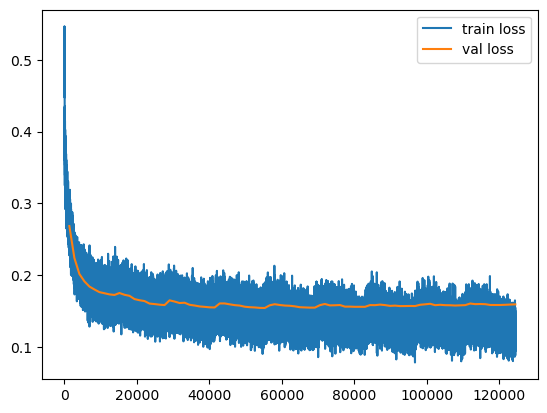

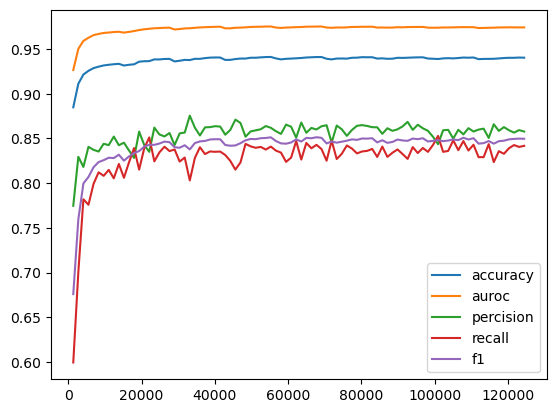

In [125]:
def plot_state():
    print(np.round(running_acc, decimals=4))
    print(np.round(running_auroc, decimals=4))
    plt.plot(np.arange(len(running_loss))[10:], running_loss[10:], label="train loss")
    plt.plot(running_val_loss_idx, running_val_loss, label="val loss")
    plt.legend()
    plt.show()
    plt.plot(running_val_loss_idx, running_acc, label="accuracy")
    plt.plot(running_val_loss_idx, running_auroc, label="auroc")
    plt.plot(running_val_loss_idx, running_percision, label="percision")
    plt.plot(running_val_loss_idx, running_recall, label="recall")
    plt.plot(running_val_loss_idx, running_f1, label="f1")
    plt.legend()
    plt.show()
plot_state()

In [126]:
def val_model_res(model, dataloader):
    model.eval()
    val_loss = 0
    results = []
    targets = []
    with torch.no_grad():
        for x_pep, x_tmhc, target in dataloader:
            res = model(x_pep, x_tmhc)
            results.append(res)
            targets.append(target)
            val_loss += nn.BCELoss(reduction='sum')(res.reshape(-1), target.reshape(-1).float()).item()
    
    res = torch.concat(results).reshape(-1)
    target = torch.concat(targets)
    accuracy = (res.reshape(-1).round() == target.reshape(-1)).float().mean().item()
    val_loss /= len(val_dataloader.dataset)
    return res, target


In [130]:
output, target = val_model_res(model, val_dataloader)

In [131]:
from torchmetrics.classification import BinaryAccuracy
val_df = df.iloc[valid_idx]
data = []
for i, mhc_type in enumerate(mhc_types):
    mask = (df['MHC_type'] == mhc_type)[valid_idx].to_numpy()
    r = output[mask].cpu()
    t = target[mask].cpu()
    res = [
        mhc_type,
        BinaryAccuracy()(r, t).item(),
        binary_precision(r, t).item(),
        binary_recall(r, t).item(),
        binary_f1_score(r, t).item(),
        sum(t).item(),
        sum(mask),
        binary_auroc(r, t).item(),
    ]
    data.append(res)
df_metrics = pd.DataFrame(data, columns=['mhc_type', 'accuracy', 'precision', 'recall', 'f1', 'positive', 'count', 'auroc'])

In [132]:
pd.set_option('display.max_rows', 500)
df_metrics.sort_values(by=['f1'])

,mhc_type,accuracy,precision,recall,f1,positive,count,auroc
61,HLA-A*30:01,0.842713,0.810526,0.277978,0.413978,277,1386,0.892227
99,HLA-B*15:03,0.865443,0.800000,0.430769,0.560000,65,327,0.903641
93,HLA-A*66:01,0.891892,1.000000,0.466667,0.636364,15,74,0.936723
100,HLA-B*48:01,0.882979,0.722222,0.684211,0.702703,19,94,0.968421
0,HLA-B*27:05,0.894270,0.800381,0.630352,0.705263,7334,36546,0.905427
82,HLA-B*83:01,0.902344,0.882353,0.588235,0.705882,51,256,0.949689
84,HLA-B*15:17,0.900763,0.844828,0.620253,0.715328,79,393,0.956583
60,HLA-A*26:03,0.909091,0.888889,0.615385,0.727273,13,66,0.956459
62,HLA-C*01:02,0.902655,0.816720,0.661458,0.730935,384,1921,0.954601
101,HLA-B*15:09,0.902439,0.785714,0.687500,0.733333,16,82,0.955492


<Axes: >

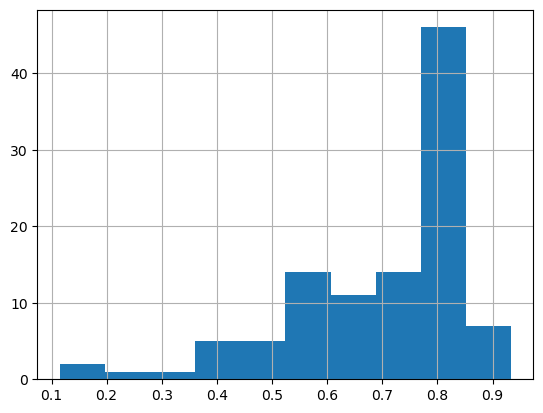

In [101]:
df_metrics['f1'].hist()